# Fourier Transformation

### Imports

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random

In [2]:
import sys
sys.version

'3.7.1 (default, Dec 14 2018, 19:28:38) \n[GCC 7.3.0]'

### main variables

In [3]:
image_path = "../images/aina_medium.jpg"

### functions

In [4]:
#Source: https://stackoverflow.com/a/42314798

def plotimage(img, title=None, figsize=None, invert=False):
    if invert:
        img = np.max(img) - img.copy()
        
    h = img.shape[0]
    w = img.shape[1]
    dpi = 80
    if figsize is None:
        figsize = w / float(dpi), h / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])    
    ax.axis('off')
    ax.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.show()

### code

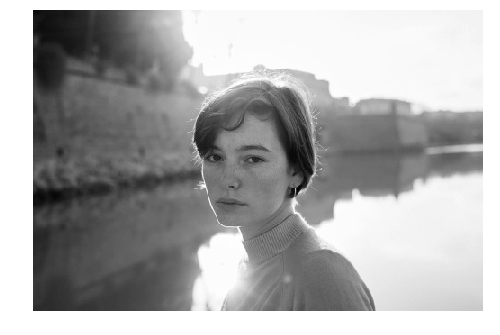

In [5]:
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plotimage(img)

### fourier

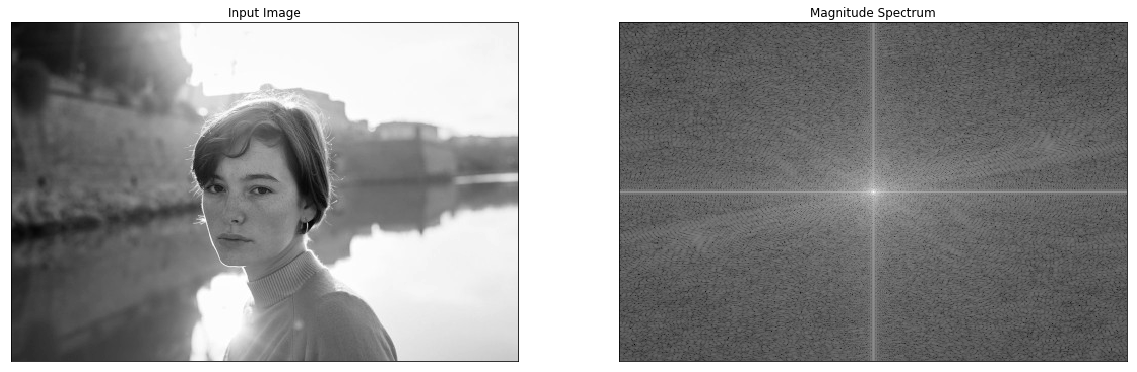

In [6]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

#for plotting
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.figure(figsize=(20,20))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()


### Inverse Fourier

/home/ghais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


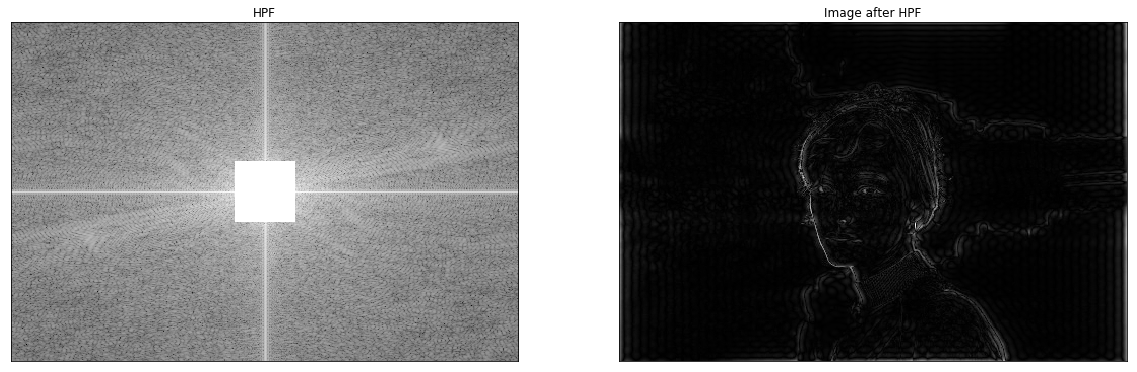

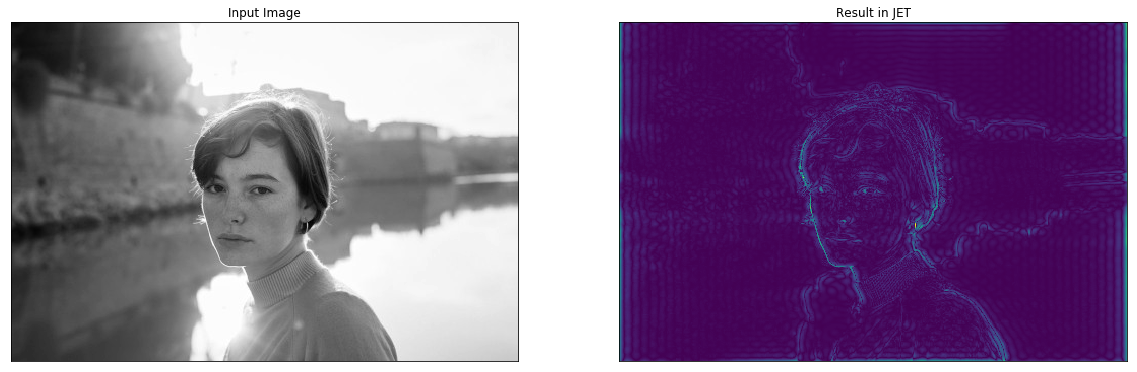

In [7]:
rows, cols = img.shape
crow,ccol = rows//2 , cols//2
fshift_hpf = fshift.copy();
keep_center = True
n = 30
# delete values near the center
if keep_center:
    fshift_hpf[crow-n:crow+n, ccol-n:ccol+n] = 0
else:
    #keep center values
    fshift_hpf[0:crow-n,0:ccol-n] = fshift_hpf[crow+n:rows,ccol+n:cols] = 0
    fshift_hpf[crow+n:rows,0:ccol-n] = fshift_hpf[0:crow-n,ccol+n:cols] = 0

f_ishift = np.fft.ifftshift(fshift_hpf)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.figure(figsize=(20,20))
magnitude_spectrum = 20*np.log(np.abs(fshift_hpf))
plt.subplot(121),plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('HPF'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(20,20))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(img_back)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])




plt.show()